### **Eserczio 12.2 - CNN**

Per migliorare le prestazioni sul riconoscimento delle cifre scritte a mano è stata implementata una rete neruale convoluzionale (CNN), adatta ad elaborare immagini.

##### **Costruzione della rete neurale**

La rete è strutturata in questo modo (immagine realizzata con [netron.app](https://netron.app/)):
<div style="text-align: center;">
  <img src="saved_models/model_CNN.png" width="10000">
</div>

  $$ \ $$

<div style="width: 49%; float: left;">
  
**Conv2D**  

Come suggerisce il nome, è un layer di convoluzione bidimensionale, che applica un insieme di filtri all’input, con l'obiettivo di estrarre caratteristiche spaziali diverse come bordi, angoli o texture. Ogni filtro è una piccola matrice che scorre sull’immagine e ne trasforma localmente i valori, producendo così una feature map che evidenzia particolari strutture.

Nel contesto delle reti neurali convoluzionali, i valori dei filtri (o kernel) non sono predefiniti, ma vengono appresi durante l’addestramento per ottimizzare il riconoscimento dei pattern rilevanti nei dati.

</div>
<div style="width: 48%; float: right;">
<div style="text-align: center;">

  <img src="filters/filtri_layer0.png" width="500">
</div>
</div>
<div style="clear: both;"></div>

**MaxPooling2D** 

Il Max Pooling è una tecnica di downsampling che fa scorrere una matrice sulla feature map, realizzata dal layer di convoluzione ed estrae il valore massimo da ciascuna finestra.   
Questo processo raggiunge due obiettivi chiave:

1. Riduzione della dimensionalità e della complessità computazionale riducendo le dimensioni della feature map.

2. Invarianza di traslazione: rende il modello robusto a piccole variazioni spaziali nelle feature di input.

$$\ $$
**Flatten**

Il layer Flatten serve a trasformare un tensore multidimensionale (in questo caso 2D) in un vettore monodimensionale. In pratica, "appiattisce" i dati mantenendo tutti i valori, ma rimuovendo la struttura spaziale. È usato, come nella nostra CNN, dopo vari layer convoluzionali e di pooling, per passare il loro output a un layer Dense, che accetta solo input vettoriali (1D), è necessario "srotolare" il tensore.

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # usa solo CPU

import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist

seed = 0
np.random.seed(seed)
tf.random.set_seed(seed)

img_rows, img_cols = 28, 28
num_classes = 10

(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

print('X_train shape before reshaping:', X_train.shape)
print('Y_train shape before encoding:', Y_train.shape)
print()

# da (n, 28, 28) → (n, 28, 28, 1)
X_train = X_train.reshape(-1, img_rows, img_cols, 1)
X_test = X_test.reshape(-1, img_rows, img_cols, 1)
print('X_train shape after reshaping:', X_train.shape)
print('X_test shape after reshaping:', X_test.shape)
# rescale data in interval [0,1]
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# convert class vectors to binary class matrices, e.g. for use with categorical_crossentropy
Y_train = keras.utils.to_categorical(Y_train, num_classes)
Y_test = keras.utils.to_categorical(Y_test, num_classes)


X_train shape before reshaping: (60000, 28, 28)
Y_train shape before encoding: (60000,)

X_train shape after reshaping: (60000, 28, 28, 1)
X_test shape after reshaping: (10000, 28, 28, 1)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - acc: 0.9874 - loss: 0.0431

===== RISULTATI =====
Test loss: 0.0338250957429409
Test accuracy: 0.9902999997138977


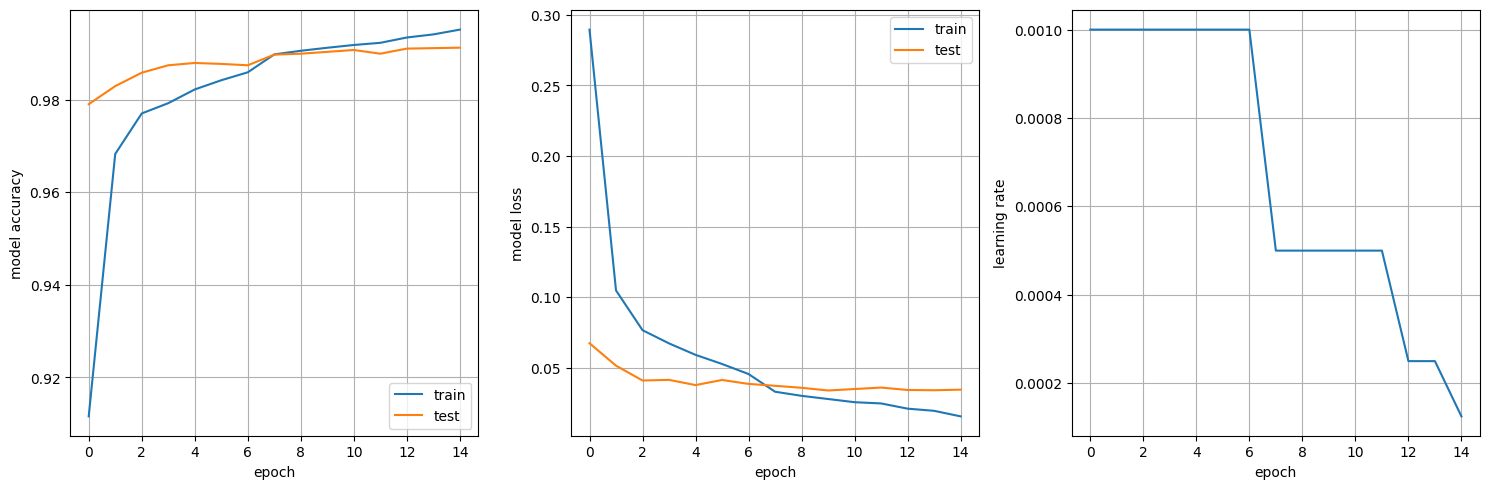

In [45]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback

def create_CNN():
    model = Sequential()
    model.add(Input(shape=(img_rows, img_cols, 1)))  # input esplicito per evitare un warning
    
    model.add(Conv2D(8, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization()) # Normalizza l’output del layer precedente per ogni mini-batch e Migliora la stabilità e velocità dell’allenamento.
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(16, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    return model

def compile_model():
    model = create_CNN()
    optimizer = Adam(learning_rate=1e-3)  # parte più alto della DNN
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['acc'])
    return model

early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2, 
    min_lr=1e-5, 
    verbose=0
)
callbacks = [early_stop, reduce_lr]

model_CNN = compile_model()

history = model_CNN.fit(X_train, Y_train,
                        batch_size=64,
                        epochs=50,
                        verbose=0,
                        validation_data=(X_test, Y_test),
                        callbacks=callbacks,
                        shuffle=True)

# evaluate model
score = model_CNN.evaluate(X_test, Y_test, verbose=1)

print("===== RISULTATI =====")
print('Test loss:', score[0])
print('Test accuracy:', score[1])

save_model_path='./saved_models/model_CNN.keras' # al posto di .h5 perhé considerato obsoleto
model_CNN.save(filepath=save_model_path, include_optimizer=True)

figure, axes = plt.subplots(1,3, figsize=(15,5))

# summarize history for accuracy
axes[0].plot(history.history['acc'])
axes[0].plot(history.history['val_acc'])
axes[0].set_ylabel('model accuracy')
axes[0].set_xlabel('epoch')
axes[0].legend(['train', 'test'], loc='lower right')
axes[0].grid(True)

# summarize history for loss
axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].set_ylabel('model loss')
axes[1].set_xlabel('epoch')
axes[1].legend(['train', 'test'], loc='best')
axes[1].grid(True)

axes[2].plot(history.history['learning_rate'])
axes[2].set_xlabel("epoch")
axes[2].set_ylabel("learning rate")
axes[2].grid(True)

plt.tight_layout()
plt.show()

**Accuracy** (a sinistra)   
L'accuratezza del modello mostra un rapido miglioramento già nelle prime epoche, segno che il modello apprende efficacemente i pattern dei dati. L’accuratezza sul training set cresce rapidamente e raggiunge valori molto elevati (vicinissimo al 100%). Anche l’accuratezza sul'inisme di vakidazione segue un trend crescente, ma si stabilizza leggermente prima, suggerendo che il modello inizia a generalizzare bene.


**Loss** (centrale)   
La loss, che misura lo scarto tra le predizioni del modello e i valori reali, diminuisce rapidamente durante le prime epoche. In particolare:
* La loss di training scende in modo deciso nelle prime 6–7 epoche.

* La loss di test diminuisce anch’essa, ma più lentamente, segno che il modello migliora anche sulla generalizzazione.

* Dopo l’epoca 7, il calo della loss rallenta notevolmente, e verso la fine dell’addestramento entrambi i valori di loss si stabilizzano, con un miglioramento marginale.

**Learning Rate** (a destra)   
Il tasso di apprendimento (learning rate) è inizialmente costante a $10^{-3}$, permettendo al modello di compiere aggiornamenti significativi dei pesi. Questo spiega il rapido calo della loss e l’aumento della accuracy nelle prime epoche.
Successivamente, all’epoca 6, viene chiamato il callback ReduceLROnPlateau che dimezza il LR a $5\cdot 10^{-4}$, poi a $2.5\cdot 10^{-4}$ e infine a $1.25\cdot 10^{-4}$. Da notare come possiamo vedere facilmente il cambiamento del LR all'interno della loss e dell'accuracy:
* Alla primo dimezzamento (epoca 7), notiamo un rallentamento nella discesa della loss e una minore variazione dell’accuracy: il modello fa piccoli passi per cercare minimi migliori.

* Ulteriori abbassamenti (epoche 11 e 13) servono a stabilizzare l’apprendimento ed evitare oscillazioni dell’ottimizzazione.

##### **Predizione sul dataset MNIST e su cifre disegnate a mano**

Come per la DNN, allenato il modello vogliamo verificarne l'accuratezza. Di seguito sono state visualizzate le predizioni su 10 cifre prese dal set di test MNIST. In ogni subplot viene mostrata l'immagine della cifra, la classe reale e la predizione del modello:

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


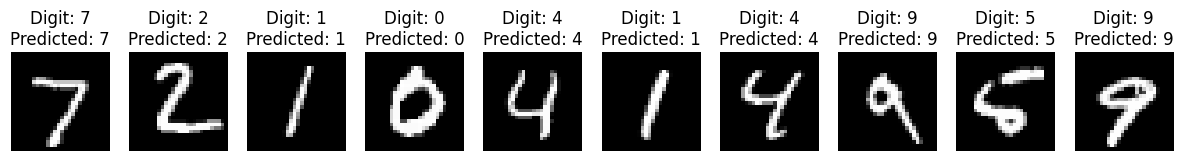

In [4]:
import keras
save_model_path='./saved_models/model_CNN.keras'
model_old = keras.models.load_model(save_model_path)
predictions = model_old.predict(X_test)

X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols,1)

plt.figure(figsize=(15, 15)) 
for i in range(10):    
    ax = plt.subplot(2, 10, i + 1)    
    plt.imshow(X_test[i, :, :, 0], cmap='gray')    
    plt.title("Digit: {}\nPredicted: {}".format(np.argmax(Y_test[i]), np.argmax(predictions[i])))    
    plt.axis('off') 
plt.show()

Di nuovo, per vedere il vero potere generalizzante della CNN ho caricato tutte le 10 cifre scritte a mano da me per vedere se, a differenza della DNN, la rete neurale convoluzionale è in grado di predirle tutte senza fare errori. 

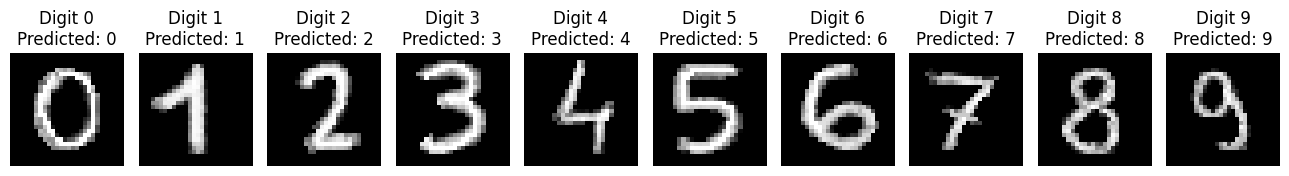

In [47]:
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt

def predict_my_number(index):
    digit_filename = f"my_numbers/{index}.png"
    digit_in = Image.open(digit_filename).convert('L')  # grayscale
    digit_in = digit_in.resize((28, 28))  # assicurati che sia 28x28

    data = np.array(digit_in).astype('float32') / 255.0
    data = data.reshape(1, 28, 28, 1)  # formato per CNN

    pred = model_old.predict(data, verbose=0)

    ax = plt.subplot(2, 10, index + 1)  # usa 2 righe x 5 colonne per 10 cifre
    plt.imshow(data.reshape(28, 28), cmap='gray')
    plt.title(f"Digit {index}\nPredicted: {np.argmax(pred)}")
    plt.axis('off')


plt.figure(figsize=(13, 13)) 
for i in range(10):
    predict_my_number(i)

plt.tight_layout()
plt.show()


##### **Appendice**

Seguono due celle di codice:

1. La prima stampa due immagini contenenti i filtri del primo e del secondo layer convoluzionale 

2. La seconda stampa un'immagine contenente un rapido schema dell'architettura della CNN , che ho preferito non usare data la presenza di strumenti più sofisticati come 'netron.app', che ho linkato sopra.

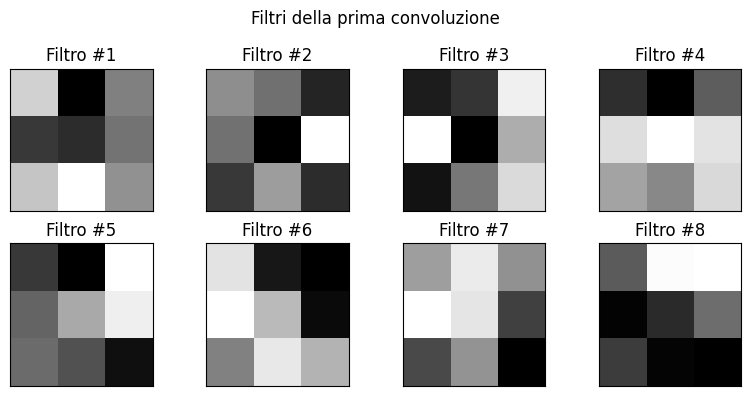

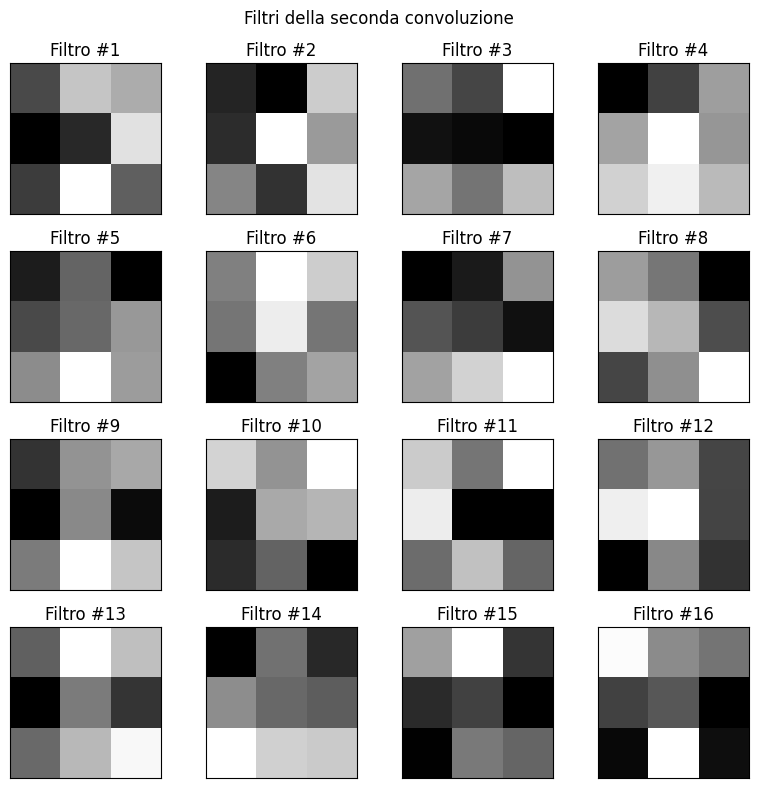

In [ ]:
layers = [0, 3] # layer 0 → 6 filtri, layer 3 → 16 filtri
layers_name=["Filtri della prima convoluzione", "Filtri della seconda convoluzione"]
for j in range(2):
    layer_index = layers[j]  
    filters, biases = model_old.layers[layer_index].get_weights()
    f_min, f_max = filters.min(), filters.max()
    filters = (filters - f_min) / (f_max - f_min)

    n_filters = filters.shape[3]
    cols = 4
    rows = (n_filters + cols - 1) // cols  # divisione intera arrotondata in alto

    plt.figure(figsize=(2 * cols, 2 * rows))  # dimensioni proporzionate
    plt.suptitle(layers_name[j])
    for i in range(n_filters):
        f = filters[:, :, :, i]
        ax = plt.subplot(rows, cols, i + 1)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.title("Filtro #" + str(i+1))
        plt.imshow(f[:, :, 0], cmap='gray')

    plt.tight_layout()
    plt.show()

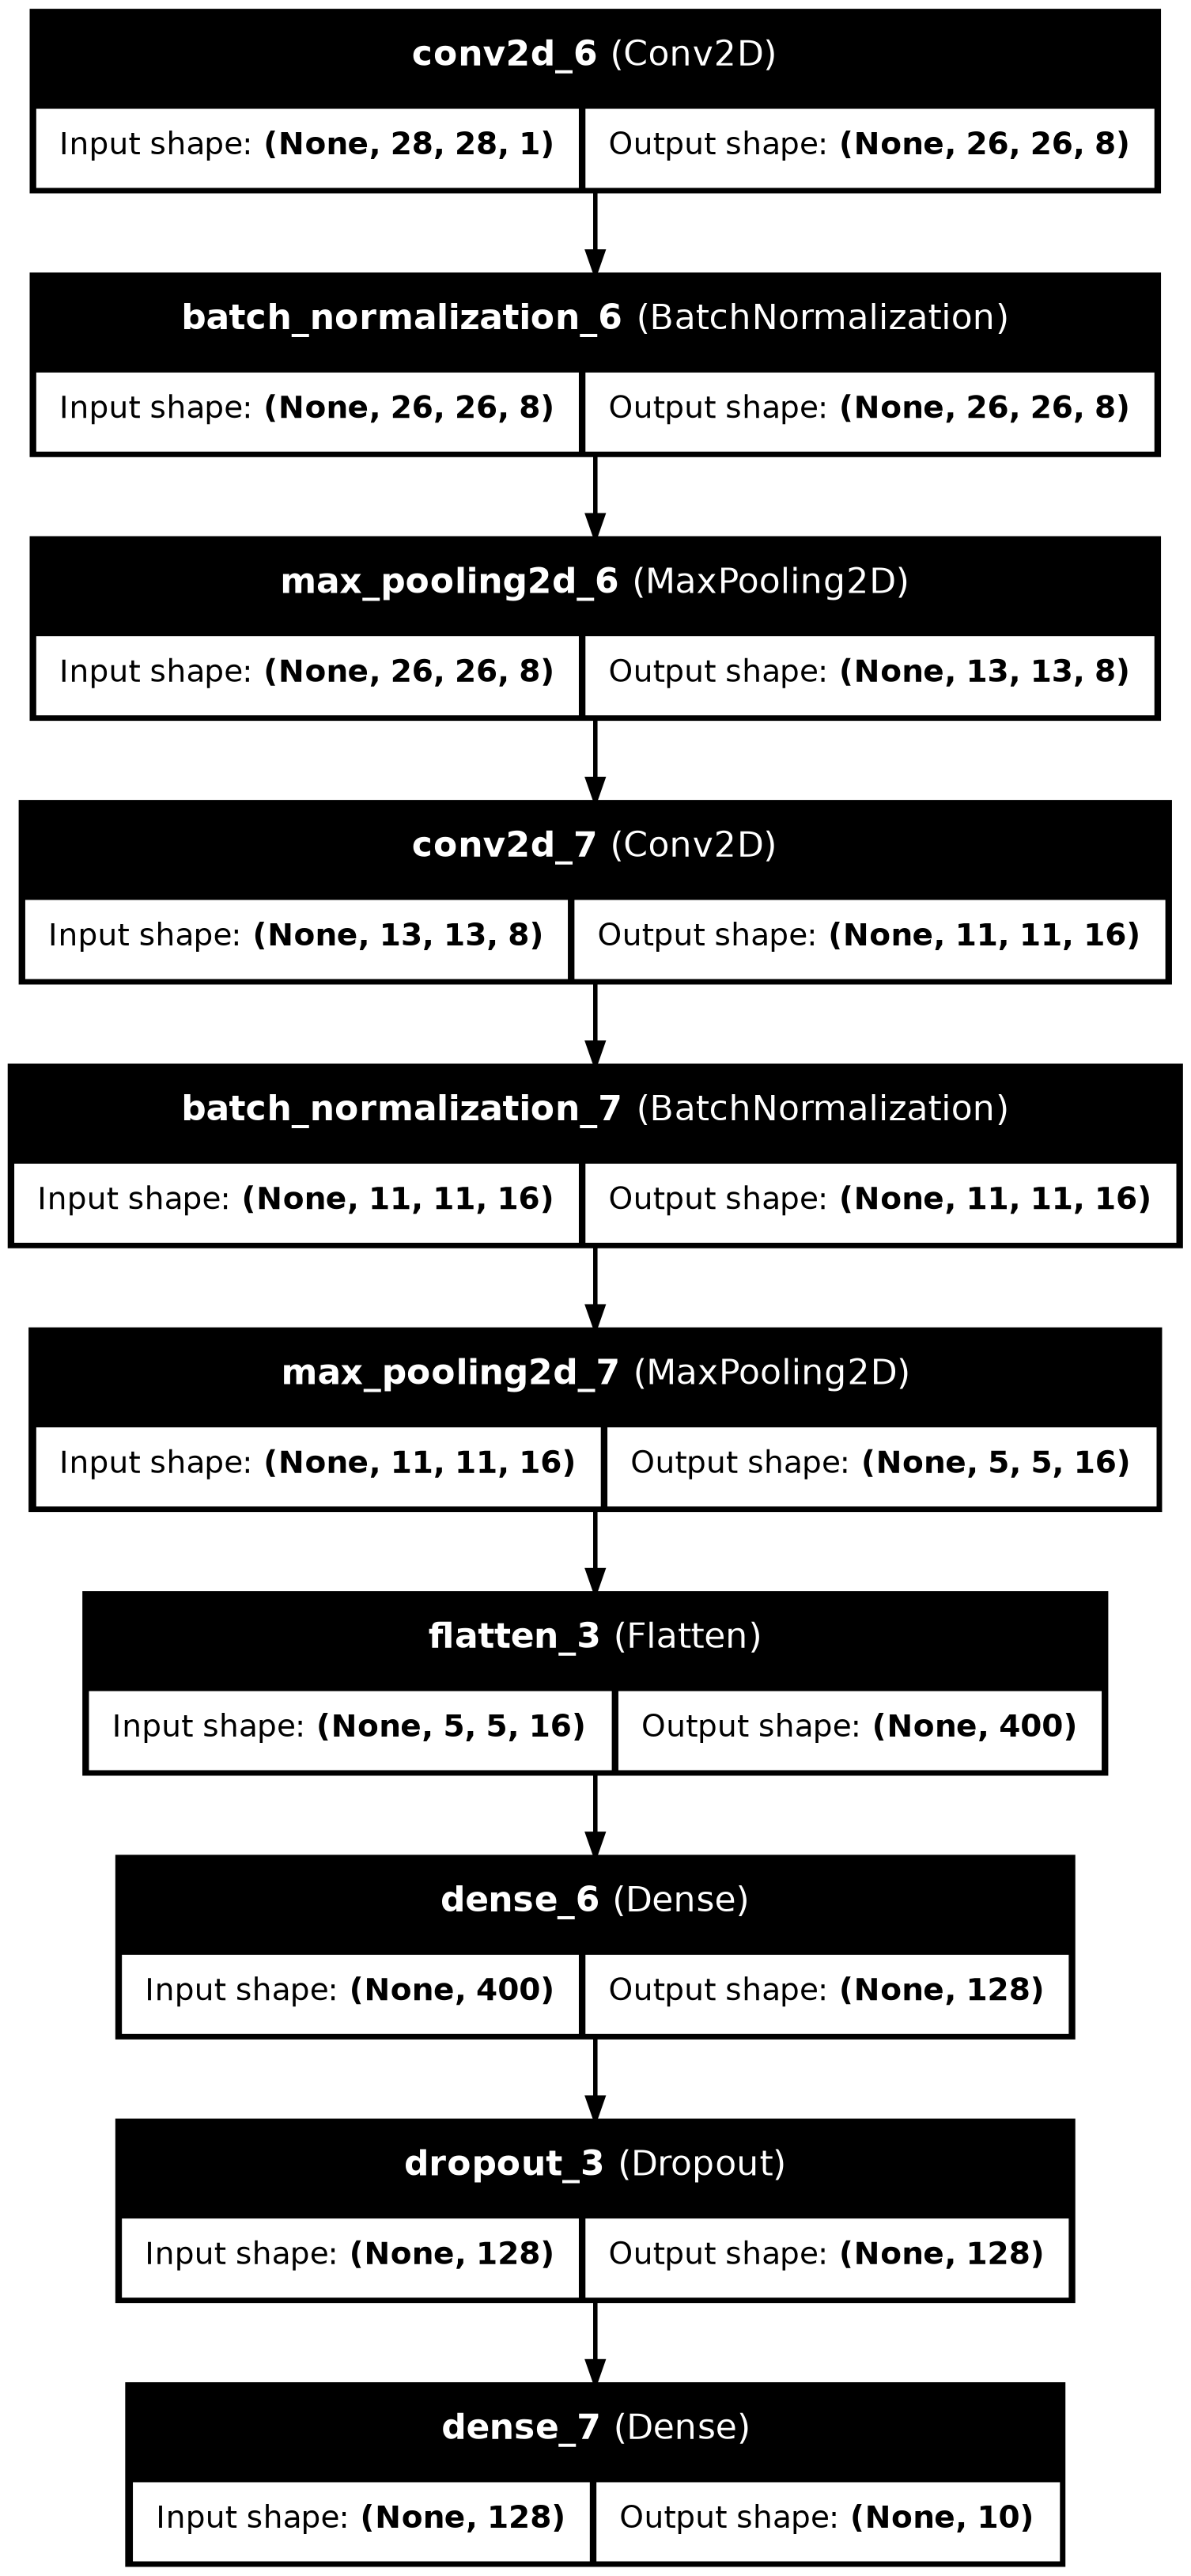

In [12]:
from keras.utils import plot_model

plot_model(model_old, to_file='model_CNN.png', show_shapes=True, show_layer_names=True) # rankdir='LR'